In [0]:
# Importing modules
import pyspark.sql.functions as F
import matplotlib.pyplot as plt

# Loading data
delays = spark.read.table("hive_metastore.default.tilinajay2")
delays

DataFrame[FL_DATE: date, OP_CARRIER: string, OP_CARRIER_FL_NUM: string, ORIGIN: string, DEST: string, DEP_DELAY: int, TAXI_OUT: int, TAXI_IN: int, ARR_DELAY: int, CANCELLED: boolean, DIVERTED: boolean, CRS_ELAPSED_TIME: int, ACTUAL_ELAPSED_TIME: int, AIR_TIME: int, DISTANCE: int, CARRIER_DELAY: int, WEATHER_DELAY: int, NAS_DELAY: int, SECURITY_DELAY: int, LATE_AIRCRAFT_DELAY: int, CRS_DEP_HOUR: int, CRS_DEP_MIN: int, DEP_HOUR: int, DEP_MIN: int, WHEELS_OFF_HOUR: int, WHEELS_OFF_MIN: int, WHEELS_ON_HOUR: int, WHEELS_ON_MIN: int, CRS_ARR_HOUR: int, CRS_ARR_MIN: int, ARR_HOUR: int, ARR_MIN: int]

**A summary table showing the number of flights per month across the history of the data**

+-------------+----------------------+
|FL_DATE_MONTH|TOTAL_FLIGHTS_BY_MONTH|
+-------------+----------------------+
|            1|               4952079|
|            2|               4576698|
|            3|               5295087|
|            4|               5110413|
|            5|               5255897|
|            6|               5860141|
|            7|               4966100|
|            8|               5454172|
|            9|               5470073|
|           10|               4646214|
|           11|               4921185|
|           12|               5048905|
+-------------+----------------------+



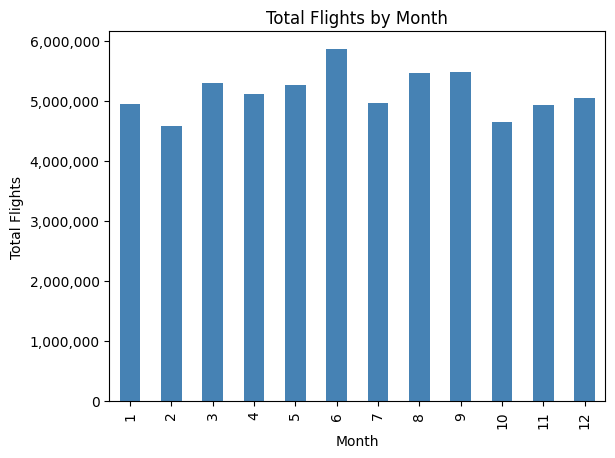

In [0]:
# Calculate the aggregates
total_flights = delays \
    .withColumn("FL_DATE_MONTH", F.month("FL_DATE")) \
    .groupBy("FL_DATE_MONTH") \
    .agg(F.count("*").alias("TOTAL_FLIGHTS_BY_MONTH")).orderBy("FL_DATE_MONTH")
    
total_flights.show()

# Create the plot
ax = total_flights.toPandas().plot(kind="bar", x="FL_DATE_MONTH", y="TOTAL_FLIGHTS_BY_MONTH", legend=False,
                                   title="Total Flights by Month", color = "steelblue")

ax.set_xlabel("Month")
ax.set_ylabel("Total Flights")
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))

# Show the plot
plt.show()              

**The percentage of flights delayed per week, plotted over the entire length of the data**

+------------+------------------+
|FL_DATE_WEEK| PERCENTAGE_DELAYS|
+------------+------------------+
|           1|23.936919460483374|
|           2| 20.13994597693506|
|           3|18.175434995719584|
|           4|14.888469610337363|
|           5| 15.93144431070193|
|           6| 18.07201261091487|
|           7| 17.03880521346036|
|           8|20.704027969790012|
|           9|18.373244225161052|
|          10| 19.12537487056039|
|          11|17.259889798146023|
|          12| 18.46708827527076|
|          13| 17.94424637114816|
|          14|18.871086275619273|
|          15|16.708827846508704|
|          16|17.674326459275278|
|          17|17.745327446342827|
|          18| 16.37928426148493|
|          19|17.746048405718003|
|          20|19.574640713389577|
+------------+------------------+
only showing top 20 rows



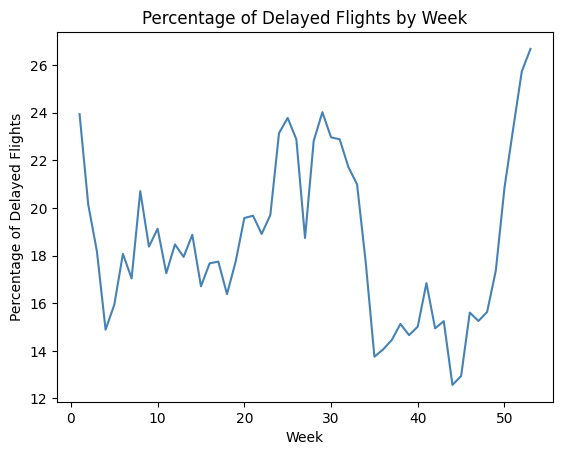

In [0]:
# Create a delay flag
delay_condition = (
    (F.col("CARRIER_DELAY") != 0) |
    (F.col("WEATHER_DELAY") != 0) |
    (F.col("NAS_DELAY") != 0) |
    (F.col("SECURITY_DELAY") != 0) |
    (F.col("LATE_AIRCRAFT_DELAY") != 0)
)

# Calculate the aggregate
perc_delayed_week = delays \
    .withColumn("FL_DATE_WEEK", F.weekofyear("FL_DATE")) \
    .withColumn("DELAYED", F.when(delay_condition, 1).otherwise(0)) \
    .groupBy("FL_DATE_WEEK") \
    .agg((F.sum(F.col("DELAYED"))/F.count("*") * 100).alias("PERCENTAGE_DELAYS")) \
    .select("FL_DATE_WEEK", "PERCENTAGE_DELAYS") \
    .orderBy("FL_DATE_WEEK")

perc_delayed_week.show()

#  Create the plot
ax = perc_delayed_week.toPandas().plot(kind="line", x="FL_DATE_WEEK", y="PERCENTAGE_DELAYS", legend=False,
                                   title="Percentage of Delayed Flights by Week", color = "steelblue")

ax.set_xlabel("Week")
ax.set_ylabel("Percentage of Delayed Flights")
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))

# Show the plot
plt.show()    

**The number of delayed flights per week, by type of delay, plotted over time**

+------------+--------------------+--------------------+----------------+---------------------+--------------------------+
|FL_DATE_WEEK|TOTAL_CARRIER_DELAYS|TOTAL_WEATHER_DELAYS|TOTAL_NAS_DELAYS|TOTAL_SECURITY_DELAYS|TOTAL_LATE_AIRCRAFT_DELAYS|
+------------+--------------------+--------------------+----------------+---------------------+--------------------------+
|           1|             5055569|              810234|         3237841|                31130|                   6470350|
|           2|             4030811|              742358|         3058920|                21131|                   5114524|
|           3|             3390340|              748865|         3112833|                10139|                   4342772|
|           4|             3041808|              492077|         2301282|                 9694|                   3272815|
|           5|             3037912|              680021|         2686060|                11310|                   3552299|
|           6|  

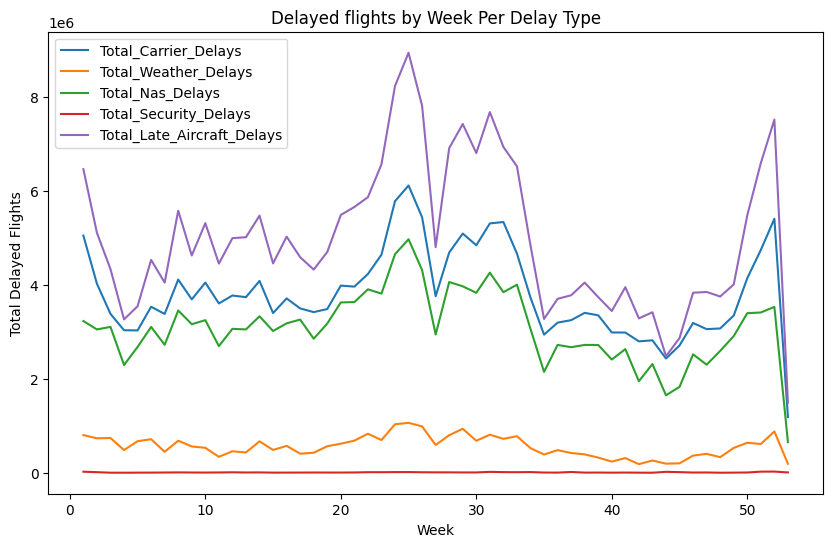

In [0]:
# Calculate the Aggregate
delayed_flights_by_week_type = delays \
    .withColumn("FL_DATE_WEEK", F.weekofyear("FL_DATE")) \
    .groupBy("FL_DATE_WEEK") \
    .agg(F.sum(F.col("CARRIER_DELAY")).alias("TOTAL_CARRIER_DELAYS"),
         F.sum(F.col("WEATHER_DELAY")).alias("TOTAL_WEATHER_DELAYS"), 
         F.sum(F.col("NAS_DELAY")).alias("TOTAL_NAS_DELAYS"), 
         F.sum(F.col("SECURITY_DELAY")).alias("TOTAL_SECURITY_DELAYS"), 
         F.sum(F.col("LATE_AIRCRAFT_DELAY")).alias("TOTAL_LATE_AIRCRAFT_DELAYS")) \
    .select("FL_DATE_WEEK", "TOTAL_CARRIER_DELAYS", "TOTAL_WEATHER_DELAYS", "TOTAL_NAS_DELAYS", "TOTAL_SECURITY_DELAYS", "TOTAL_LATE_AIRCRAFT_DELAYS") \
    .orderBy("FL_DATE_WEEK")

delayed_flights_by_week_type.show()

# Create the plot
plt.figure(figsize=(10, 6)) 
for i in ["TOTAL_CARRIER_DELAYS", "TOTAL_WEATHER_DELAYS", "TOTAL_NAS_DELAYS", "TOTAL_SECURITY_DELAYS", "TOTAL_LATE_AIRCRAFT_DELAYS"]:
    plt.plot(delayed_flights_by_week_type.select("FL_DATE_WEEK").toPandas(),
             delayed_flights_by_week_type.select(i).toPandas(),
             label=i.title())
    
plt.title("Delayed flights by Week Per Delay Type")
plt.xlabel("Week")
plt.ylabel("Total Delayed Flights")
plt.legend()

# Show the plot
plt.show()

**A table of air carriers, showing the number of flights scheduled, the number canceled, the percentage delayed, and the average delay among those delayed. Sort by total number of flights, so the biggest air carriers come first.**

In [0]:
# Create a delay flag
delay_condition = (
    (F.col("CARRIER_DELAY") != 0) |
    (F.col("WEATHER_DELAY") != 0) |
    (F.col("NAS_DELAY") != 0) |
    (F.col("SECURITY_DELAY") != 0) |
    (F.col("LATE_AIRCRAFT_DELAY") != 0)
)

# Calculate the aggregate
delays \
    .withColumn("DELAYED", F.when(delay_condition, 1).otherwise(0)) \
    .groupBy("OP_CARRIER") \
    .agg(
        F.count("OP_CARRIER_FL_NUM").alias("TOTAL_FLIGHTS_SCHEDULED"),
        F.sum(F.when(F.col("CANCELLED") == 1, 1).otherwise(0)).alias("TOTAL_CANCELLED_FLIGHTS"),
        (F.sum("DELAYED") / F.count("*") * 100).alias("PERCENTAGE_DELAYED_FLIGHTS"),
         F.avg(F.when(F.col("DELAYED") == 1, F.col("ARR_DELAY"))).alias("AVERAGE_DELAYED_FLIGHTS")) \
    .select("OP_CARRIER", "TOTAL_FLIGHTS_SCHEDULED", "TOTAL_CANCELLED_FLIGHTS", "PERCENTAGE_DELAYED_FLIGHTS",   
            "AVERAGE_DELAYED_FLIGHTS") \
    .orderBy("TOTAL_FLIGHTS_SCHEDULED", ascending=False) \
    .show()

+----------+-----------------------+-----------------------+--------------------------+-----------------------+
|OP_CARRIER|TOTAL_FLIGHTS_SCHEDULED|TOTAL_CANCELLED_FLIGHTS|PERCENTAGE_DELAYED_FLIGHTS|AVERAGE_DELAYED_FLIGHTS|
+----------+-----------------------+-----------------------+--------------------------+-----------------------+
|        WN|               12096540|                 133587|         19.15313800475177|      49.26288949689386|
|        DL|                7841880|                  62966|        14.945102449922723|     60.049621280963706|
|        AA|                6682161|                 108555|        19.451312232674432|      59.51256454998123|
|        OO|                6263052|                 114445|        17.826931662071463|      62.86955871420766|
|        UA|                4826658|                  58635|         18.62021299209515|      63.11143452901526|
|        EV|                4726445|                 137042|        21.368597328436064|      67.46608183

**Table of top 50 airports by percentage of flights delayed, showing the airport code, percentage of flights delayed, and average number of flights per day**

In [0]:
# Calculate the percentage of flights delays
perc_airport_delays = delays \
    .groupBy("ORIGIN") \
    .agg((F.sum(F.when(F.col("DEP_DELAY") >= 15, 1).otherwise(0)) / F.count("*") * 100).alias("PERCENTAGE_DELAYED"))

# Calculate the flights per day
flights_per_day = delays \
    .groupBy("ORIGIN", "FL_DATE") \
    .count() \
    .groupBy("ORIGIN") \
    .agg(F.avg("count").alias("AVG_FLIGHTS_PER_DAY"))

airport_summary = perc_airport_delays.join(flights_per_day, "ORIGIN") \
    .orderBy(F.desc("PERCENTAGE_DELAYED")) \
    .limit(50) \
    .show()

+------+------------------+-------------------+
|ORIGIN|PERCENTAGE_DELAYED|AVG_FLIGHTS_PER_DAY|
+------+------------------+-------------------+
|   YNG|             100.0|                1.0|
|   ENV|             100.0|                1.0|
|   TKI|             100.0|                1.0|
|   PIR| 66.66666666666666|                1.0|
|   MCN|              50.0|                1.0|
|   SCK| 39.49129852744311|  2.104225352112676|
|   HGR| 36.95652173913043|                1.0|
|   OWB| 35.13513513513514|                1.0|
|   OTH| 34.76450315910397|  2.166770379589297|
|   CEC| 33.81190514599129|  2.786067415730337|
|   OGD| 32.53968253968254|              1.008|
|   MVY|30.267558528428097|  1.812121212121212|
|   UST| 29.86798679867987| 1.0376712328767124|
|   PSM|  29.7029702970297| 1.5459183673469388|
|   BLV|27.968596663395484|  3.154798761609907|
|   ADK|27.019230769230766| 1.0166177908113392|
|   LCK|26.752767527675275| 3.4743589743589745|
|   PGV|25.669642857142854|  4.246445497

In [0]:
# END